In [1]:
using JLD, PyPlot

In [2]:
archivo="../JLDFiles/TrabajandoKyKTilde/LFP_Promedio_est_con5.jld"

"../JLDFiles/TrabajandoKyKTilde/LFP_Promedio_est_con5.jld"

In [3]:
Arxivo=load(archivo)

Dict{String,Any} with 12 entries:
  "KTT_KInv"         => [0.710605 0.155257 … -5.54059e-5 -2.93594e-5; 0.168929 …
  "latencia"         => 27
  "kCSDCorrecta"     => [0.0 -4.33223 … 13.3719 12.5651; 2.28279 -0.443459 … 14…
  "final"            => 1072
  "KTilde"           => [28.1263 33.76 … 1.19496 0.892065; 27.0489 36.982 … 1.2…
  "Canalesrespuesta" => Set(Array{Int64,1}[[33, 57], [25, 39], [33, 56], [30, 4…
  "retrazo"          => 90
  "freq"             => 17.8555
  "LFPSaturados"     => [4125.0 7.38525 … 20.813 6.71387; 22.1558 18.7988 … 11.…
  "Nota"             => "Usamos las siguientes B y BT para obtener las Ks: Bcer…
  "K"                => [7521.15 3890.8 … 1624.32 1592.52; 3890.8 8100.04 … 165…
  "CanalesSaturados" => Set(Array{Int64,1}[[11, 63], [41, 46], [6, 37], [44, 23…

In [4]:
LFP=Arxivo["LFPSaturados"];

In [5]:
(alto,ancho,tmax)=size(LFP)
retrazo=Arxivo["retrazo"]

90

In [6]:
freq=Arxivo["freq"]
#retrazo=Arxivo["retrazo"]

17.85550205219098

In [7]:
K=Arxivo["K"]
KTilde=Arxivo["KTilde"];
longus=size(K,1)
K=K/maximum(K)
KTilde=KTilde/maximum(KTilde);
for j =1:longus
    K[j,j]=K[j,j]/2.0
end

### Estabilización de K

In [8]:
KTT=0
KTTaux=0

0

In [9]:
if nprocs()==1
    addprocs(7)
end

7-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8

In [10]:
@everywhere function kktestable(K,KTilde, λ)
    Kdc=deepcopy(K)
    longus=size(K,1)
    for j in 1:longus
        Kdc[j,j]=Kdc[j,j]*(1+λ)
    end
    ktt=transpose(KTilde)*inv(Kdc)
    return ktt
end

In [11]:
lmax=7
inter=0.1
#KTTaux=SharedArray{Float64,3}(longus,longus,lmax);
#@sync @parallel for l=1:lmax
KTTaux=SharedArray{Float64,3}(longus,longus,lmax)
@time @sync @parallel for l=1:lmax
    λ=inter*l/lmax
    KTTaux[:,:,l]=kktestable(K,KTilde,λ)
    println("tuabuela")
end;
KTT=copy(KTTaux)
KTTaux0=0

	From worker 2:	tuabuela
	From worker 3:	tuabuela
	From worker 4:	tuabuela
	From worker 8:	tuabuela
	From worker 6:	tuabuela
	From worker 7:	tuabuela
	From worker 5:	tuabuela
386.043470 seconds (327.87 k allocations: 18.031 MiB, 0.00% gc time)


0

In [12]:
KTT[10,23,2]

-0.027746148458357777

In [14]:
ioff()
farofa, lista=subplots(2,5, figsize=(25,20))
vlim=40
for l=1:lmax
    pu=ceil(Int,l/5)
    pa=mod(l,5)
    reallambda=(1+inter*l/lmax)
    if pa==0; pa=5;end
   # println(pa,", ",pu)
    lista[pu,pa][:imshow](KTT[:,:,l],cmap="viridis")
    lista[pu,pa][:set_title]("lambda = $reallambda")
end
savefig("Variosktt01.png",dpi=92)
PyPlot.close_figs()

In [15]:

saturados=Arxivo["CanalesSaturados"]

Set(Array{Int64,1}[[11, 63], [41, 46], [6, 37], [44, 23], [9, 41], [9, 43], [15, 43], [1, 1], [35, 2], [13, 22]  …  [29, 55], [31, 18], [10, 31], [1, 12], [13, 21], [13, 45], [56, 51], [10, 38], [31, 46], [7, 49]])

In [16]:
ejemplo=LFP[:,:,130]
todaslasX=Array[]

ncuad=64
Ntot=ncuad^2

for j=1:ncuad,k=1:ncuad
    push!(todaslasX,[j,k])
end

xpurgadas=filter(q->!(q in saturados), todaslasX)
nbuenas=length(xpurgadas)

lfpv=zeros(nbuenas)

println("Acomodando los LFP correctos")

println("nbuenas", nbuenas)

for j=1:nbuenas
    
    renglon=xpurgadas[j][1]
    columna=xpurgadas[j][2]
    lfpv[j]=ejemplo[renglon,columna]
end


Acomodando los LFP correctos
nbuenas4065


In [17]:
CSD=zeros(64,64,lmax)

for l in 1:lmax
    CSDTentativa=KTT[:,:,l]*lfpv 

    for j=1:nbuenas
        renglon=xpurgadas[j][1]
        columna=xpurgadas[j][2]
        CSD[renglon,columna,l]=CSDTentativa[j]
    end
end
println("terminando calculo")
#writedlm("EjemplitokCSD.dat",CSD)

terminando calculo


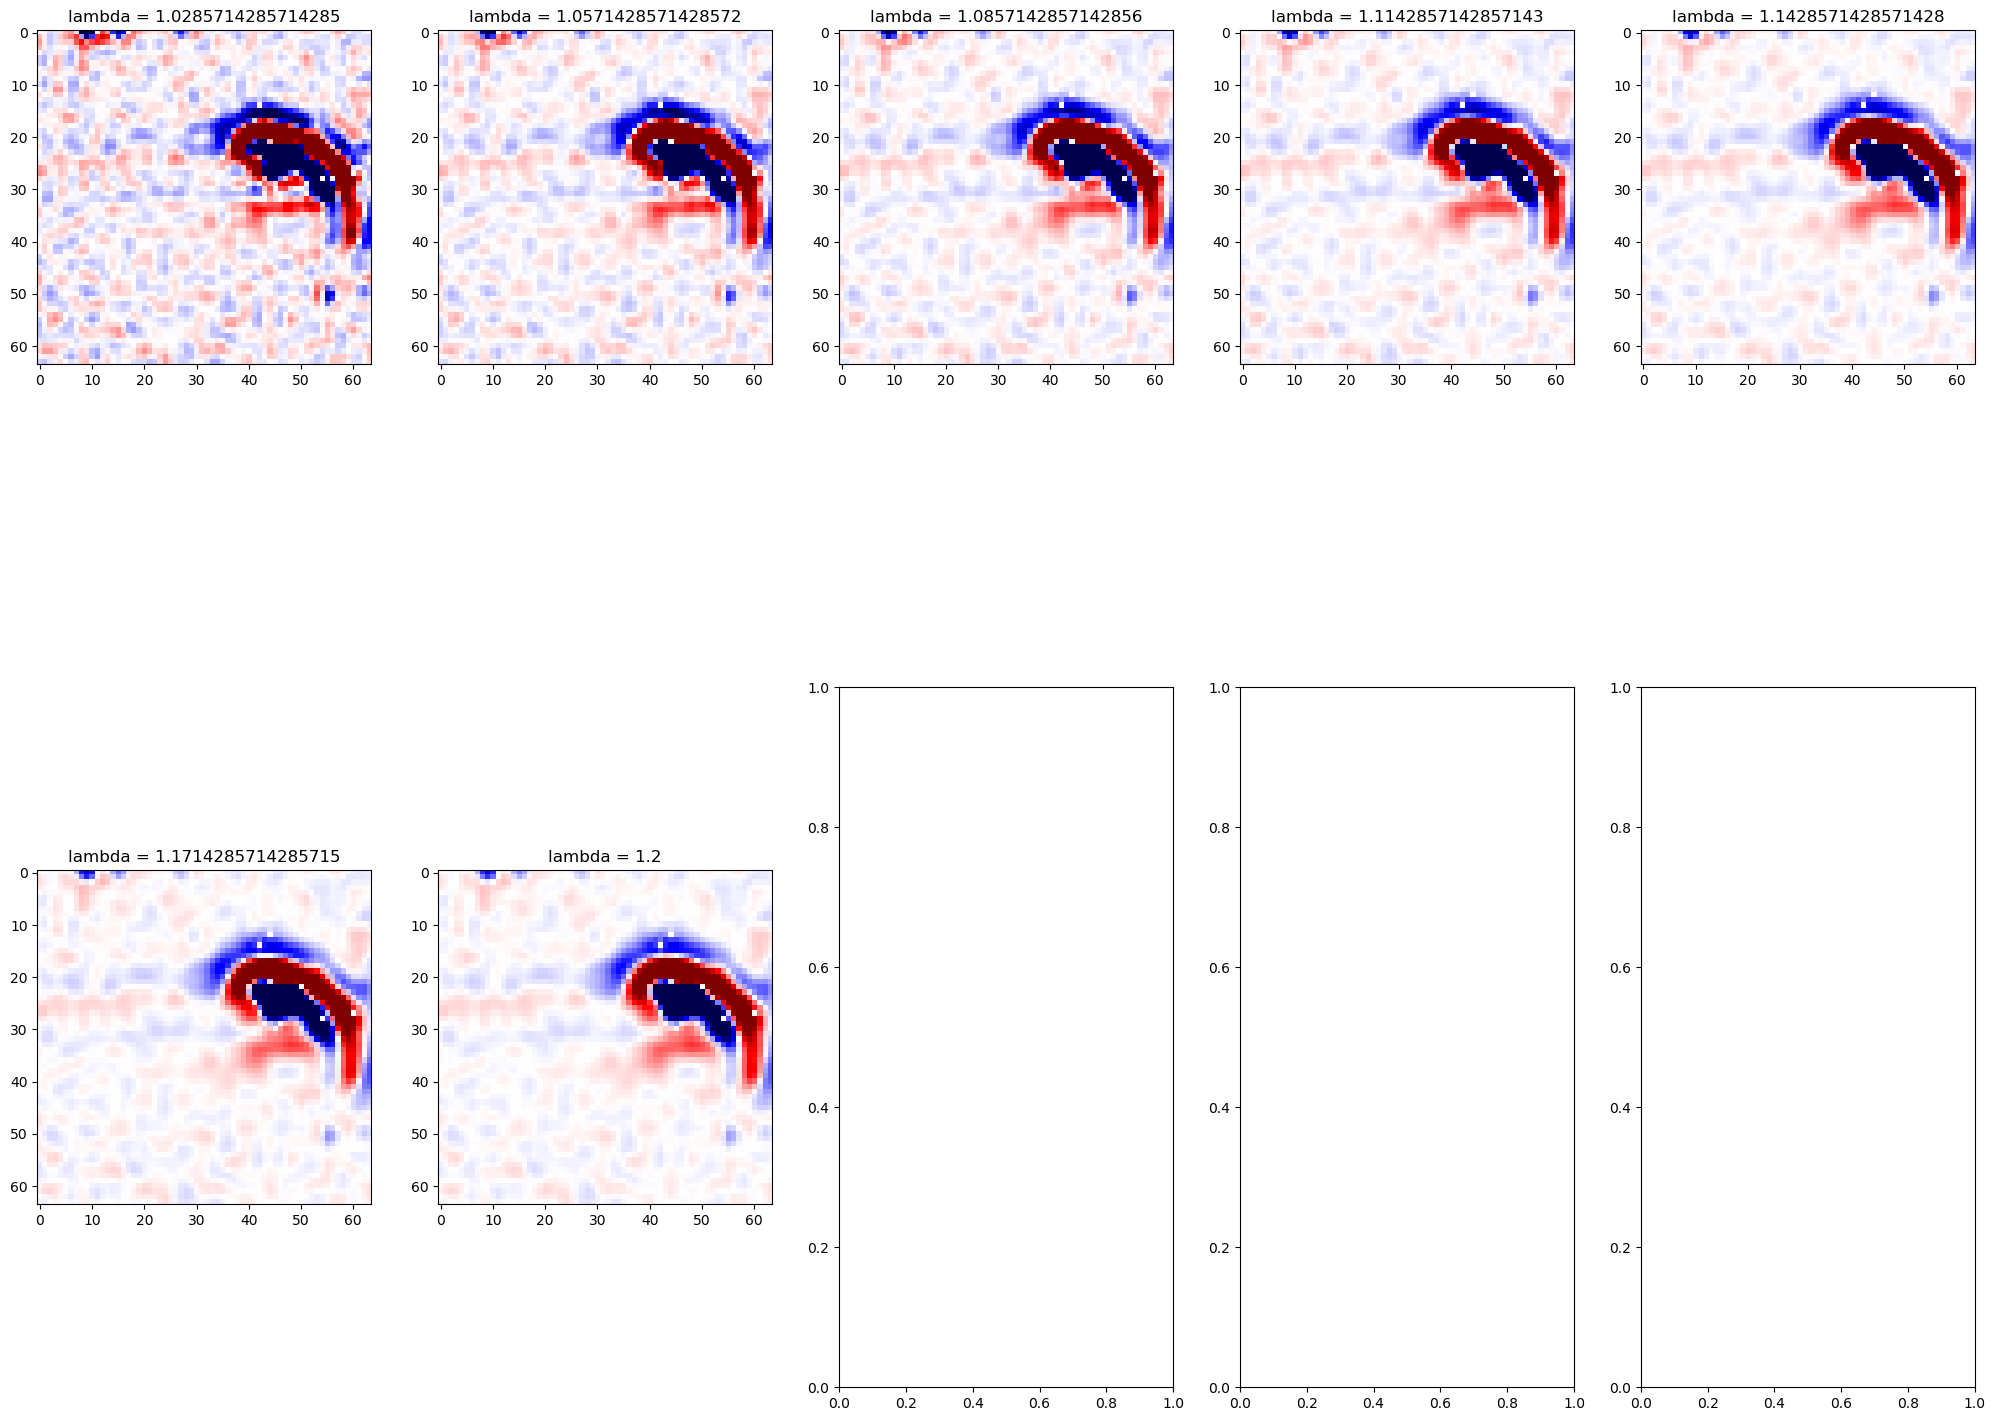

In [19]:
farofa, lista=subplots(2,5, figsize=(25,20))
vlim=4000
intervalo=0.2
for l=1:lmax
    pu=ceil(Int,l/5)
    pa=mod(l,5)
    reallambda=(1+intervalo*l/lmax)
    if pa==0; pa=5;end
   # println(pa,", ",pu)
    lista[pu,pa][:imshow](CSD[:,:,l],cmap="seismic", vmin=-vlim, vmax=vlim, interpolation="nearest")
    lista[pu,pa][:set_title]("lambda = $reallambda")
end
savefig("VarioskCSD03.png",dpi=92)